### Video Analytics-Assignment 1
### Ashish Vashistha
#### 2024AA05043

### Problem Statement

Goal: Build a comparative classical video classification system that loads videos, samples frames using multiple strategies, preprocesses and enhances frames, extracts color/texture/shape/motion/temporal features, trains SVM/RF/kNN, evaluates with comprehensive metrics, and provides comparative analysis & deployability discussion.

Dataset & Task:

* Dataset organized in class folders with split files in splits/.
* Classification Task: Multi-class labeling of videos into predefined categories.

### Library Imports

In [2]:
import os, time, json, math, warnings
import cv2
import numpy as np
import pandas as pd
import joblib
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import skew
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report,
    roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
from collections import Counter
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from skimage.filters import gabor

### Dataset is arranged as per recommended instructions in Assignment

DATA_ROOT/

├─ class_1/

│  ├─ video_001.mp4

│  ├─ video_002.mp4

│  └─ ...

├─ class_2/

│  ├─ video_101.mp4

│  └─ ...

├─ ...

├─ splits/

│  ├─ train.txt

│  ├─ val.txt

│  └─ test.txt

├─ dataset_info.txt

└─ README.md

#### Configuration (Paths + Constants)

In [3]:
DATA_ROOT = r"Dataset"
SPLITS_DIR = os.path.join(DATA_ROOT, "splits")

TRAIN_TXT = os.path.join(SPLITS_DIR, "train.txt")
VAL_TXT   = os.path.join(SPLITS_DIR, "val.txt")
TEST_TXT  = os.path.join(SPLITS_DIR, "test.txt")

# Classical resizing target (as required)
RESIZE_W, RESIZE_H = 320, 240

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

print("DATA_ROOT:", DATA_ROOT)
print("Splits:", TRAIN_TXT, VAL_TXT, TEST_TXT, sep="\n  - ")

DATA_ROOT: Dataset
Splits:
  - Dataset/splits/train.txt
  - Dataset/splits/val.txt
  - Dataset/splits/test.txt


#### Read split files (Dataset structure as per splits)

In [4]:
def read_split_file(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: 
                continue
            rel, lab = line.split()
            rows.append((rel.replace("\\", "/"), int(lab)))
    return rows

train_rows = read_split_file(TRAIN_TXT)
val_rows   = read_split_file(VAL_TXT)
test_rows  = read_split_file(TEST_TXT)

print("Split sizes:", len(train_rows), len(val_rows), len(test_rows))
print("First 3 train rows:", train_rows[:3])

Split sizes: 54 12 9
First 3 train rows: [('Basketball/v_Basketball_g01_c07.avi', 0), ('Basketball/v_Basketball_g20_c07.avi', 0), ('Basketball/v_Basketball_g06_c04.avi', 0)]


#### OpenCV video loader (Basic inspection + Visualization)

In [5]:
def load_video_opencv(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open: {video_path}")
        
    fps = cap.get(cv2.CAP_PROP_FPS) or 0
    nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 0)
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)
    return cap, fps, nframes, w, h

# Pick one sample video from training set
sample_rel, sample_label = train_rows[0]
sample_abs = os.path.join(DATA_ROOT, sample_rel)

cap, fps, nframes, w, h = load_video_opencv(sample_abs)
print("Sample video:", sample_rel)
print(f"Label={sample_label} | fps={fps:.2f} | frames={nframes} | size={w}x{h}")
cap.release()

Sample video: Basketball/v_Basketball_g01_c07.avi
Label=0 | fps=29.97 | frames=100 | size=320x240


#### Frame sampling strategies

In [6]:
def read_all_frames(video_path, max_frames=None):
    cap = cv2.VideoCapture(video_path)
    frames = []
    i = 0
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frames.append(frame)
        i += 1
        if max_frames and i >= max_frames:
            break
    cap.release()
    return frames

def show_frames_grid(frames, title="", cols=5, figsize=(12,6)):
    if len(frames) == 0:
        print("No frames to show")
        return
    rows = math.ceil(len(frames)/cols)
    plt.figure(figsize=figsize)
    for i, fr in enumerate(frames):
        plt.subplot(rows, cols, i+1)
        rgb = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

##### (A) Uniform sampling: 1 fps (or fixed N frames)

Uniform sampling -> stride=30 | selected=4/100


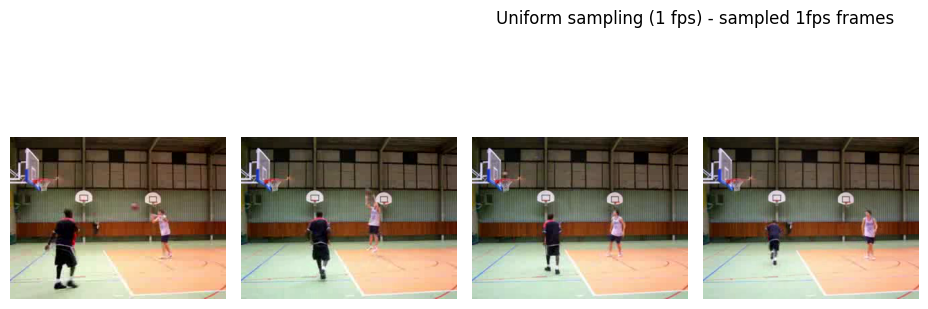

In [7]:
def uniform_sampling(frames, fps, target_fps=1.0):
    if fps <= 0:
        # fallback: sample fixed stride
        stride = max(1, len(frames)//10)
    else:
        stride = max(1, int(round(fps / target_fps)))
    sampled = frames[::stride]
    return sampled, stride

frames = read_all_frames(sample_abs, max_frames=None)
sampled_uniform, stride = uniform_sampling(frames, fps, target_fps=1.0)
print(f"Uniform sampling -> stride={stride} | selected={len(sampled_uniform)}/{len(frames)}")

show_frames_grid(sampled_uniform[:12], title="Uniform sampling (1 fps) - sampled 1fps frames", cols=6, figsize=(14,4))

#### (B) Dense sampling: every frame

Dense sampling -> selected = 100


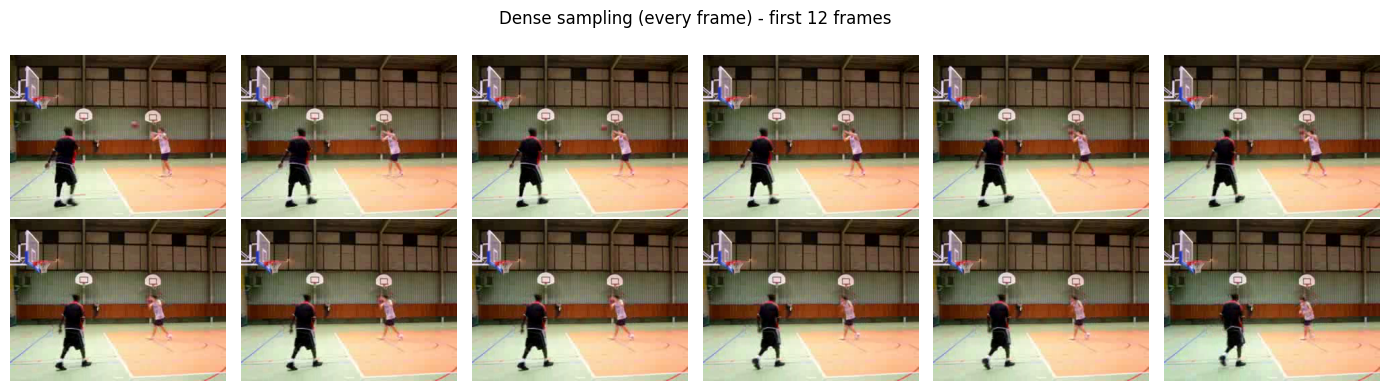

In [8]:
dense = frames  # all frames
print("Dense sampling -> selected =", len(dense))

show_frames_grid(dense[:12], title="Dense sampling (every frame) - first 12 frames", cols=6, figsize=(14,4))

#### (C) Random sampling (augmentation): selecting K random frames

Random sampling -> indices: [ 7  8  9 19 40 52 59 66 69 80] ... total: 12


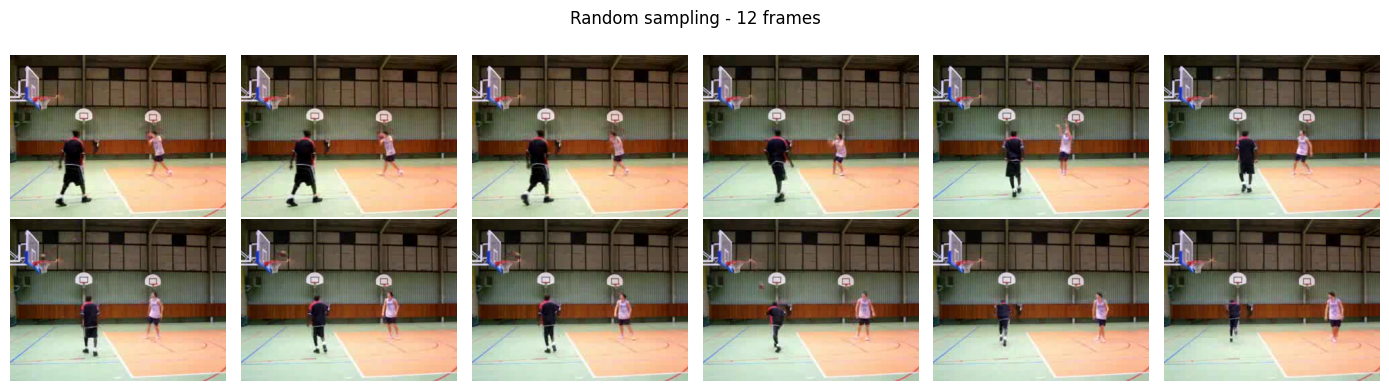

In [9]:
def random_sampling(frames, k=16, rng=None):
    rng = rng or np.random.default_rng(0)
    if len(frames) <= k:
        return frames
    idx = rng.choice(len(frames), size=k, replace=False)
    idx = np.sort(idx)
    return [frames[i] for i in idx], idx

sampled_rand, idx = random_sampling(frames, k=12, rng=rng)
print("Random sampling -> indices:", idx[:10], "... total:", len(idx))

show_frames_grid(sampled_rand, title="Random sampling - 12 frames", cols=6, figsize=(14,4))

#### Resizing check (320×240)

Resized frame shape (H,W,C): (240, 320, 3)


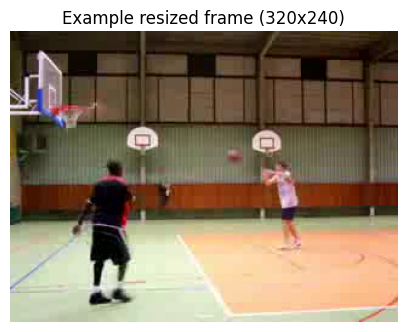

In [10]:
f0 = sampled_uniform[0]
print("Resized frame shape (H,W,C):", f0.shape)

plt.figure(figsize=(5,4))
plt.imshow(cv2.cvtColor(f0, cv2.COLOR_BGR2RGB))
plt.title("Example resized frame (320x240)")
plt.axis("off")
plt.show()

### Preprocessing & Quality Enhancement

#### Detect noise / blur / compression artifacts + handling
* Blur: variance of Laplacian (low = blurry)
* Noise estimate: high-frequency residual variance
* Compression/blockiness: approximate block boundary discontinuities

Quality scores: blurVar=446.6 | noiseStd=7.06 | blockiness=8.53


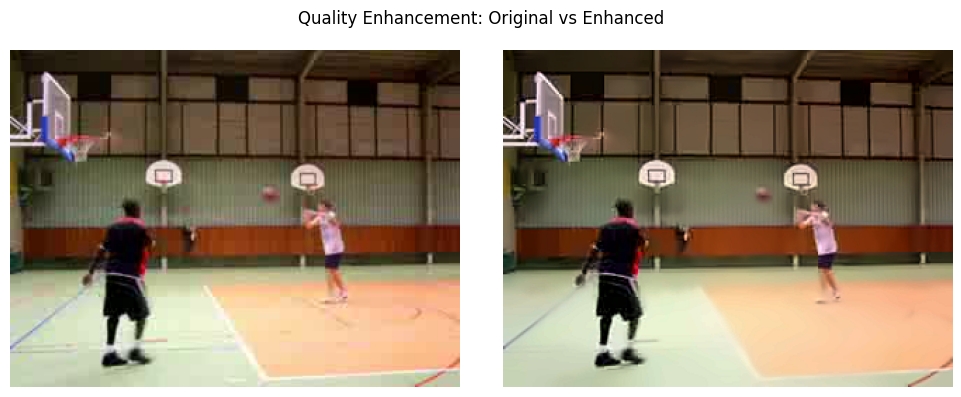

In [11]:
def blur_score(frame_bgr):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def noise_score(frame_bgr):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    resid = gray - blur
    return float(np.std(resid))

def blockiness_score(frame_bgr, block=8):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
    H, W = gray.shape

    if W <= block or H <= block:
        return float('nan')

    # Indices of block boundaries
    ks_w = np.arange(block, W, block)  # vertical boundaries between columns
    ks_h = np.arange(block, H, block)  # horizontal boundaries between rows

    if ks_w.size == 0 or ks_h.size == 0:
        return float('nan')

    # Discontinuities across boundaries
    v = np.mean(np.abs(gray[:, ks_w] - gray[:, ks_w - 1]))
    h = np.mean(np.abs(gray[ks_h, :] - gray[ks_h - 1, :]))

    return float((v + h) / 2.0)

def enhance_frame(frame_bgr):
    # Denoise (good for compression/noise)
    den = cv2.fastNlMeansDenoisingColored(frame_bgr, None, 5, 5, 7, 21)
    # Mild sharpening for blur (unsharp mask)
    ga = cv2.GaussianBlur(den, (0,0), 1.0)
    sharp = cv2.addWeighted(den, 1.5, ga, -0.5, 0)
    return sharp

fr0 = sampled_uniform[0]
b = blur_score(fr0)
n = noise_score(fr0)
blk = blockiness_score(fr0)

print(f"Quality scores: blurVar={b:.1f} | noiseStd={n:.2f} | blockiness={blk:.2f}")

enh = enhance_frame(fr0)
show_frames_grid([fr0, enh], title="Quality Enhancement: Original vs Enhanced", cols=2, figsize=(10,4))

#### Frame normalization (pixel scaling)

Normalized dtype: float32 | min/max: 0.0 1.0
Before min/max: 0 255
After  min/max: 0.0 1.0


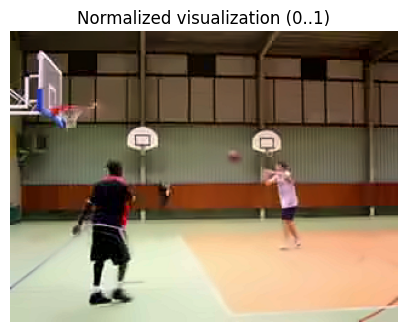

In [12]:
def normalize_frame(frame_bgr):
    # convert to float in [0,1]
    return frame_bgr.astype(np.float32) / 255.0

norm = normalize_frame(enh)
print("Normalized dtype:", norm.dtype, "| min/max:", float(norm.min()), float(norm.max()))

print("Before min/max:", enh.min(), enh.max())
print("After  min/max:", norm.min(), norm.max())

plt.figure(figsize=(5,4))
plt.imshow(cv2.cvtColor((norm*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title("Normalized visualization (0..1)")
plt.axis("off")
plt.show()

#### Color space conversions (RGB / HSV / grayscale)

RGB shape: (240, 320, 3) | HSV shape: (240, 320, 3) | Gray shape: (240, 320)


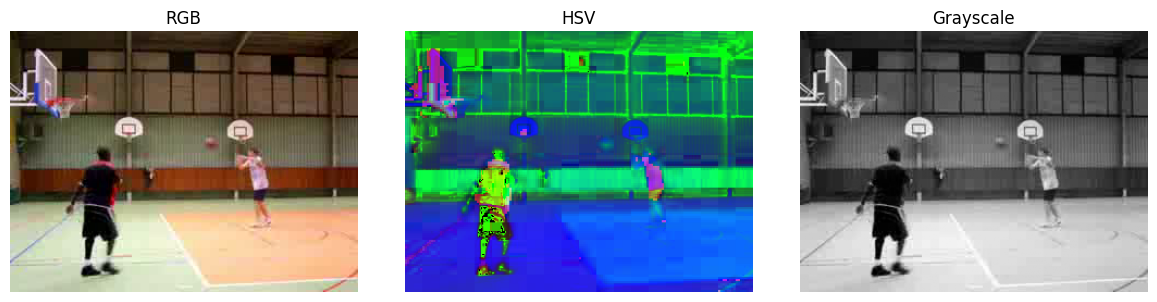

In [13]:
def convert_spaces(frame_bgr):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    return rgb, hsv, gray

rgb, hsv, gray = convert_spaces(fr0)
print("RGB shape:", rgb.shape, "| HSV shape:", hsv.shape, "| Gray shape:", gray.shape)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); plt.imshow(rgb); plt.title("RGB"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(hsv); plt.title("HSV"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(gray, cmap="gray"); plt.title("Grayscale"); plt.axis("off")
plt.tight_layout(); plt.show()

### Feature Normalization (StandardScaler + missing handling)

In [14]:
# We will do this later after we build feature vectors for all videos, here just loading the functions

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

print("Imputer + StandardScaler ready.")

Imputer + StandardScaler ready.


## Feature Extraction Methods (Classical)

### Low-Level Features

#### A) Color Features (histograms, moments, average color)

RGB hist feature length: 48


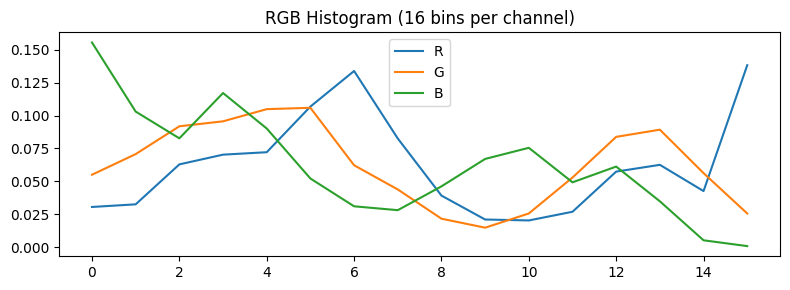

Color moments: [1.3208119e+02 5.6076382e+03 3.0089197e-01 1.1376966e+02 5.4268594e+03
 3.2916078e-01 8.9726303e+01 4.5973442e+03 3.9678657e-01]
Avg RGB: [132.08119 113.76966  89.7263 ]


In [15]:
def color_hist_rgb(frame_bgr, bins=16):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    feats = []
    for ch in range(3):
        hist = cv2.calcHist([rgb],[ch],None,[bins],[0,256]).flatten()
        hist = hist / (hist.sum() + 1e-9)
        feats.append(hist)
    return np.concatenate(feats)

def color_hist_hsv(frame_bgr, bins=16):
    hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    feats = []
    for ch in range(3):
        hist = cv2.calcHist([hsv],[ch],None,[bins],[0,256]).flatten()
        hist = hist / (hist.sum() + 1e-9)
        feats.append(hist)
    return np.concatenate(feats)

def color_moments(frame_bgr):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
    feats = []
    for ch in range(3):
        v = rgb[:,:,ch].reshape(-1)
        feats.extend([v.mean(), v.var(), skew(v)])
    return np.array(feats, dtype=np.float32)

def avg_color(frame_bgr):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
    return rgb.reshape(-1,3).mean(axis=0)

# Demo visualization (RGB histogram)
h = color_hist_rgb(fr0, bins=16)
print("RGB hist feature length:", len(h))

plt.figure(figsize=(8,3))
plt.plot(h[:16], label="R")
plt.plot(h[16:32], label="G")
plt.plot(h[32:48], label="B")
plt.title("RGB Histogram (16 bins per channel)")
plt.legend(); plt.tight_layout(); plt.show()

print("Color moments:", color_moments(fr0))
print("Avg RGB:", avg_color(fr0))

#### B1) Texture Features (GLCM)

GLCM length: 24


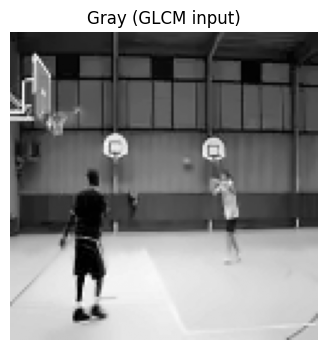

In [16]:
def glcm_feats(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (128,128))
    q = (gray/16).astype(np.uint8)
    glcm = graycomatrix(q, distances=[1,2], angles=[0, np.pi/4], levels=16, symmetric=True, normed=True)
    props = []
    for prop in ["contrast","dissimilarity","homogeneity","energy","correlation","ASM"]:
        props.extend(graycoprops(glcm, prop).flatten())
    return np.array(props, dtype=np.float32), gray

gf, gimg = glcm_feats(enh)
print("GLCM length:", len(gf))

plt.figure(figsize=(4,4))
plt.imshow(gimg, cmap="gray")
plt.title("Gray (GLCM input)")
plt.axis("off")
plt.show()

#### B2) Texture Features (LBP)

LBP hist len: 32


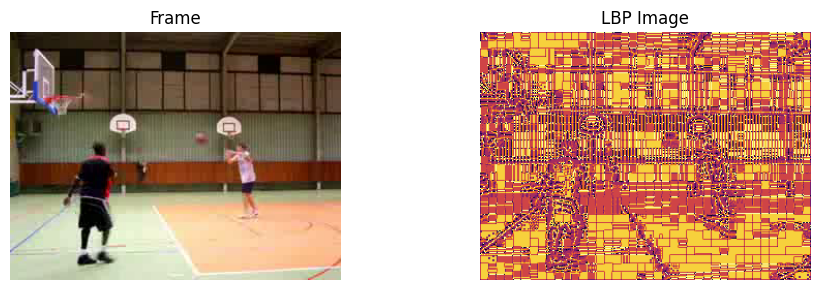

In [17]:
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.filters import gabor

def glcm_features(frame_bgr, distances=[1,2], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    # quantize to reduce matrix size
    gray_q = (gray // 16).astype(np.uint8)  # 0..15
    glcm = graycomatrix(gray_q, distances=distances, angles=angles, levels=16, symmetric=True, normed=True)
    props = ["contrast","dissimilarity","homogeneity","energy","correlation","ASM"]
    feats = []
    for p in props:
        vals = graycoprops(glcm, p).flatten()
        feats.extend(vals)
    return np.array(feats, dtype=np.float32)

def lbp_features(frame_bgr, P=8, R=1, bins=32):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins), density=True)
    return hist.astype(np.float32), lbp

def gabor_features(frame_bgr, freqs=(0.2, 0.4), thetas=(0, np.pi/4, np.pi/2)):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    feats = []
    for f in freqs:
        for t in thetas:
            real, imag = gabor(gray, frequency=f, theta=t)
            mag = np.sqrt(real**2 + imag**2)
            feats.extend([mag.mean(), mag.var()])
    return np.array(feats, dtype=np.float32)

gl = glcm_features(fr0)
lbp_hist, lbp_img = lbp_features(fr0)
gab = gabor_features(fr0)

print("LBP hist len:", len(lbp_hist))

plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(fr0, cv2.COLOR_BGR2RGB)); plt.title("Frame"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(lbp_img, cmap="inferno"); plt.title("LBP Image"); plt.axis("off")
plt.tight_layout(); plt.show()

#### B3) Texture Features (Gabor)

Gabor length: 24


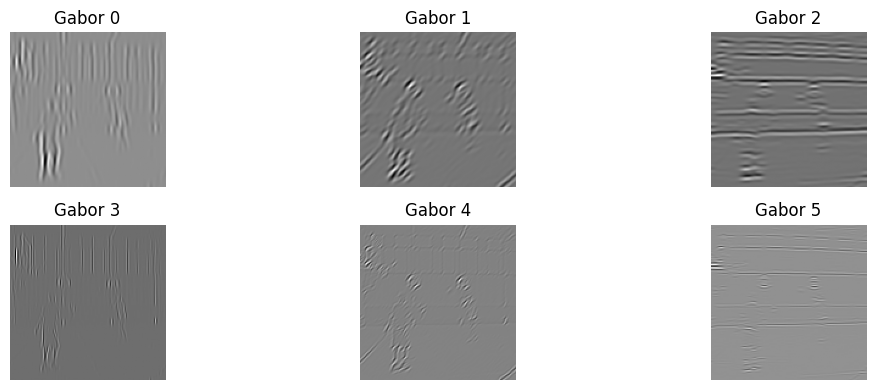

In [18]:
def gabor_feats(bgr, freqs=(0.2, 0.4), thetas=(0, np.pi/4, np.pi/2)):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (128,128)).astype(np.float32)/255.0
    feats = []
    previews = []
    for f in freqs:
        for t in thetas:
            real, imag = gabor(gray, frequency=f, theta=t)
            feats += [real.mean(), real.var(), imag.mean(), imag.var()]
            previews.append(real)
    return np.array(feats, dtype=np.float32), previews

gabf, previews = gabor_feats(enh)
print("Gabor length:", len(gabf))

plt.figure(figsize=(12,4))
for i in range(min(6, len(previews))):
    plt.subplot(2,3,i+1)
    plt.imshow(previews[i], cmap="gray")
    plt.title(f"Gabor {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()

#### C1) Shape Features (Canny)

Edge hist len: 16


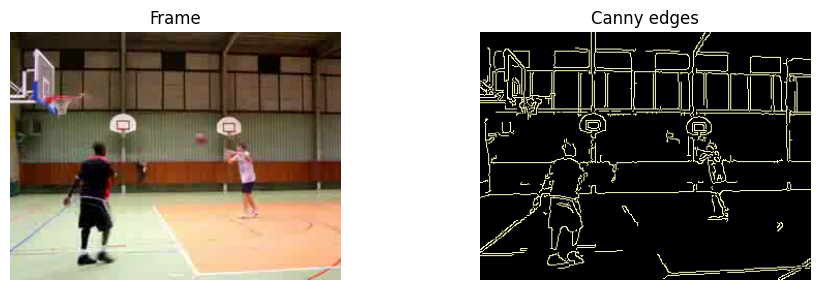

In [19]:


def edge_histogram(frame_bgr, bins=16):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 80, 160)
    # histogram of edge pixels along x-axis
    proj = edges.sum(axis=0).astype(np.float32)
    hist, _ = np.histogram(proj, bins=bins, density=True)
    return hist.astype(np.float32), edges

def contour_features(frame_bgr):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 80, 160)
    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return np.zeros(6, dtype=np.float32)
    areas = np.array([cv2.contourArea(c) for c in cnts], dtype=np.float32)
    peris = np.array([cv2.arcLength(c, True) for c in cnts], dtype=np.float32)
    feats = [
        float(len(cnts)),
        float(areas.mean()), float(areas.var()),
        float(peris.mean()), float(peris.var()),
        float(areas.max())
    ]
    return np.array(feats, dtype=np.float32)

def hog_features(frame_bgr):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    feat = hog(gray, orientations=9, pixels_per_cell=(8,8),
               cells_per_block=(2,2), block_norm="L2-Hys",
               visualize=False, feature_vector=True)
    return feat.astype(np.float32)

eh, edges = edge_histogram(fr0)
cf = contour_features(fr0)
hf = hog_features(fr0)

print("Edge hist len:", len(eh))

plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(fr0, cv2.COLOR_BGR2RGB)); plt.title("Frame"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(edges, cmap="magma"); plt.title("Canny edges"); plt.axis("off")
plt.tight_layout(); plt.show()

#### C2) Shape Features (Contours)

Contour feats: [ 102.        65.98529 1974.5      102.83077 1436.7006 ]


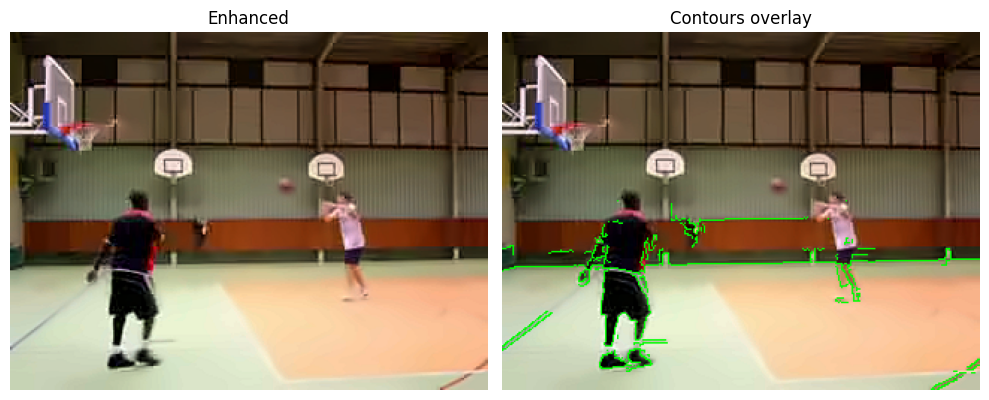

In [20]:
def contour_feats(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    ed = cv2.Canny(gray, 80, 160)
    cnts, _ = cv2.findContours(ed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in cnts]
    peris = [cv2.arcLength(c, True) for c in cnts]
    feats = np.array([
        len(cnts),
        np.mean(areas) if areas else 0,
        np.max(areas) if areas else 0,
        np.mean(peris) if peris else 0,
        np.max(peris) if peris else 0
    ], dtype=np.float32)

    vis = bgr.copy()
    cv2.drawContours(vis, cnts[:50], -1, (0,255,0), 1)
    return feats, vis

cf, cvis = contour_feats(enh)
print("Contour feats:", cf)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(enh, cv2.COLOR_BGR2RGB)); plt.title("Enhanced"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(cvis, cv2.COLOR_BGR2RGB)); plt.title("Contours overlay"); plt.axis("off")
plt.tight_layout(); plt.show()

#### C3) Shape Features (HOG)

HOG length: 8100


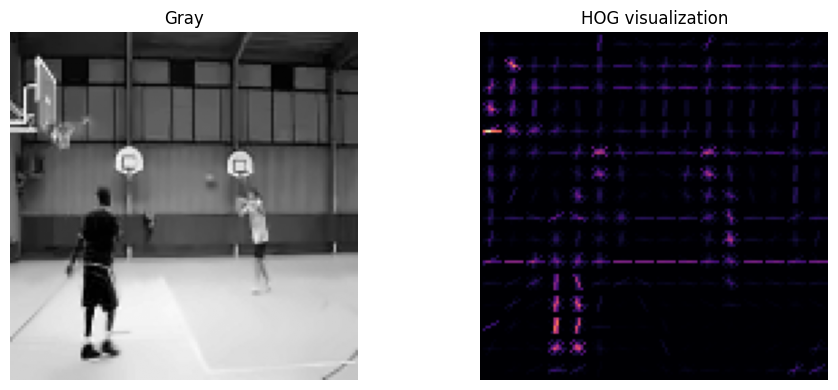

In [21]:
def hog_feats(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (128,128))
    feat, hog_img = hog(gray, orientations=9, pixels_per_cell=(8,8),
                        cells_per_block=(2,2), visualize=True, feature_vector=True)
    return feat.astype(np.float32), hog_img, gray

hf, hog_img, gray_ = hog_feats(enh)
print("HOG length:", len(hf))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(gray_, cmap="gray"); plt.title("Gray"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(hog_img, cmap="magma"); plt.title("HOG visualization"); plt.axis("off")
plt.tight_layout(); plt.show()

### Motion Features

#### A) Frame Differencing (abs diff + stats + hist)

In [22]:
import cv2

def frame_diff_features(
    frames_bgr,
    diff_hist_bins=16,
    motion_hist_bins=16,
    add_motion_hist_to_features=True
):
    # Feature lengths
    base_len = 8 + diff_hist_bins + (motion_hist_bins if add_motion_hist_to_features else 0)

    if len(frames_bgr) < 2:
        # Always return SAME dimensionality to avoid model mismatch later
        return (
            np.zeros(base_len, dtype=np.float32),
            None,
            np.array([], dtype=np.float32),
            np.zeros(diff_hist_bins, dtype=np.float32),
            np.zeros(motion_hist_bins, dtype=np.float32)
        )

    diffs = []
    mags = []

    for i in range(1, len(frames_bgr)):
        g1 = cv2.cvtColor(frames_bgr[i-1], cv2.COLOR_BGR2GRAY).astype(np.float32)
        g2 = cv2.cvtColor(frames_bgr[i],   cv2.COLOR_BGR2GRAY).astype(np.float32)
        d = np.abs(g2 - g1)
        diffs.append(d)
        mags.append(d.mean())

    mags = np.array(mags, dtype=np.float32)

    # --- Pixel-level histogram of diff intensities ---
    all_pixels = np.concatenate([d.ravel() for d in diffs])
    pixel_hist, _ = np.histogram(
        all_pixels, bins=diff_hist_bins, range=(0, 255), density=True
    )
    pixel_hist = pixel_hist.astype(np.float32)

    # --- Stats from motion intensity sequence ---
    feats = np.array([
        mags.mean(),
        mags.std(),
        mags.min(),
        mags.max(),
        np.percentile(mags, 25),
        np.percentile(mags, 50),
        np.percentile(mags, 75),
        float(len(frames_bgr))
    ], dtype=np.float32)

    # --- Motion intensity histogram (distribution of mags) ---
    mag_max = float(mags.max()) + 1e-6
    motion_hist, _ = np.histogram(
        mags, bins=motion_hist_bins, range=(0, mag_max), density=True
    )
    motion_hist = motion_hist.astype(np.float32)

    # --- Build final feature vector ---
    if add_motion_hist_to_features:
        feat_vec = np.concatenate([feats, pixel_hist, motion_hist]).astype(np.float32)
    else:
        feat_vec = np.concatenate([feats, pixel_hist]).astype(np.float32)

    # Safety
    feat_vec = np.nan_to_num(feat_vec, nan=0.0, posinf=0.0, neginf=0.0)

    diff_first = diffs[0]
    return feat_vec, diff_first, mags, pixel_hist, motion_hist

Frame-diff feature length: 24


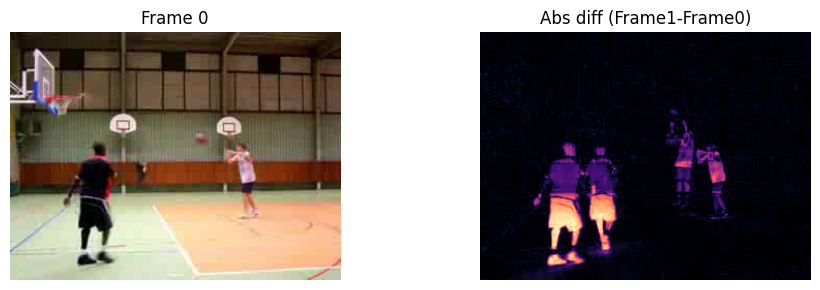

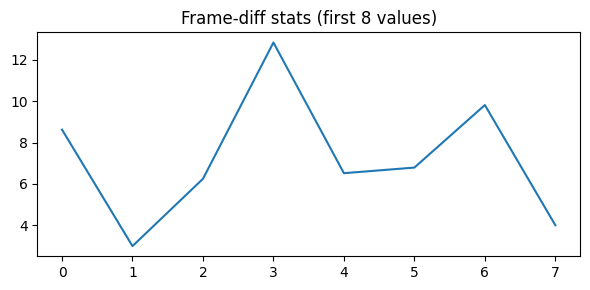

In [23]:
def frame_diff_features(frames_bgr):
    # needs >= 2 frames
    if len(frames_bgr) < 2:
        return np.zeros(8, dtype=np.float32), None
    
    diffs = []
    mags = []
    for i in range(1, len(frames_bgr)):
        g1 = cv2.cvtColor(frames_bgr[i-1], cv2.COLOR_BGR2GRAY).astype(np.float32)
        g2 = cv2.cvtColor(frames_bgr[i],   cv2.COLOR_BGR2GRAY).astype(np.float32)
        d = np.abs(g2 - g1)
        diffs.append(d)
        mags.append(d.mean())
    
    mags = np.array(mags, dtype=np.float32)
    # intensity histogram of diffs
    hist, _ = np.histogram(np.concatenate([d.ravel() for d in diffs]), bins=16, range=(0,255), density=True)

    feats = np.array([
        mags.mean(), mags.std(), mags.min(), mags.max(),
        np.percentile(mags, 25), np.percentile(mags, 50), np.percentile(mags, 75),
        float(len(frames_bgr))
    ], dtype=np.float32)
    return np.concatenate([feats, hist.astype(np.float32)]), diffs[0]

motion_fd_feat, diff_vis = frame_diff_features(sampled_uniform[:10])
print("Frame-diff feature length:", len(motion_fd_feat))

plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(sampled_uniform[0], cv2.COLOR_BGR2RGB)); plt.title("Frame 0"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(diff_vis, cmap="magma"); plt.title("Abs diff (Frame1-Frame0)"); plt.axis("off")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(motion_fd_feat[:8])
plt.title("Frame-diff stats (first 8 values)")
plt.tight_layout(); plt.show()

#### B) Optical Flow (Lucas–Kanade sparse)

LK sparse feat: [1.16455574e+01 1.81090164e+01 1.32198054e-02 1.13575516e+02
 2.52637297e-01 7.01760054e-02 1.98000000e+02 1.66542456e-01
 2.71499138e+01 6.84410557e-02]


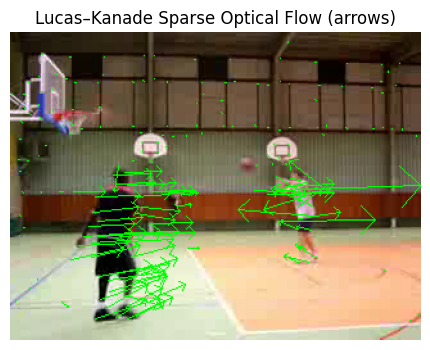

In [24]:
def lucas_kanade_sparse(frames_bgr, max_corners=200):
    if len(frames_bgr) < 2:
        return np.zeros(10, dtype=np.float32), None
    
    prev = cv2.cvtColor(frames_bgr[0], cv2.COLOR_BGR2GRAY)
    nextf = cv2.cvtColor(frames_bgr[1], cv2.COLOR_BGR2GRAY)

    p0 = cv2.goodFeaturesToTrack(prev, maxCorners=max_corners, qualityLevel=0.01, minDistance=7)
    if p0 is None:
        return np.zeros(10, dtype=np.float32), None

    p1, st, err = cv2.calcOpticalFlowPyrLK(prev, nextf, p0, None)
    good0 = p0[st==1]
    good1 = p1[st==1]
    flow = good1 - good0  # vectors

    mag = np.linalg.norm(flow, axis=1)
    ang = np.arctan2(flow[:,1], flow[:,0])

    feats = np.array([
        mag.mean(), mag.std(), mag.min(), mag.max(),
        np.cos(ang).mean(), np.sin(ang).mean(),
        float(len(mag)), float(np.median(mag)),
        float(np.percentile(mag, 75)), float(np.percentile(mag, 25))
    ], dtype=np.float32)

    # visualize
    vis = frames_bgr[0].copy()
    for (x0,y0),(x1,y1) in zip(good0.reshape(-1,2), good1.reshape(-1,2)):
        cv2.arrowedLine(vis, (int(x0),int(y0)), (int(x1),int(y1)), (0,255,0), 1, tipLength=0.2)
    return feats, vis

lk_feat, lk_vis = lucas_kanade_sparse(sampled_uniform[:2])
print("LK sparse feat:", lk_feat)

plt.figure(figsize=(10,4))
plt.imshow(cv2.cvtColor(lk_vis, cv2.COLOR_BGR2RGB))
plt.title("Lucas–Kanade Sparse Optical Flow (arrows)")
plt.axis("off")
plt.show()

#### B) Optical Flow (Horn–Schunck dense)

HS flow shapes: (120, 160) (120, 160) (120, 160)
Avg motion intensity: 0.0004353119002189487 Max: 0.00818205438554287


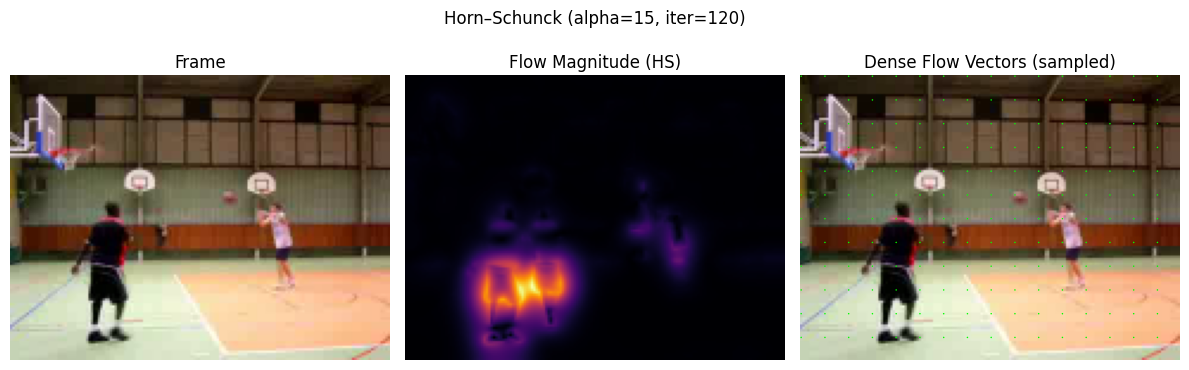

In [25]:
def _to_gray_float(frame_bgr):
    """BGR uint8 -> grayscale float32 in [0,1]."""
    g = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    return g

def horn_schunck_dense(
    frame0_bgr,
    frame1_bgr,
    alpha=15.0,
    n_iter=100,
    flow_resize=(160, 120),
    return_debug=False
):
    if flow_resize is not None:
        w, h = flow_resize
        f0 = cv2.resize(frame0_bgr, (w, h), interpolation=cv2.INTER_AREA)
        f1 = cv2.resize(frame1_bgr, (w, h), interpolation=cv2.INTER_AREA)
    else:
        f0, f1 = frame0_bgr, frame1_bgr

    I0 = _to_gray_float(f0)
    I1 = _to_gray_float(f1)

    kx = np.array([[-1, 1],
                   [-1, 1]], dtype=np.float32) * 0.25
    ky = np.array([[-1, -1],
                   [ 1,  1]], dtype=np.float32) * 0.25
    kt = np.ones((2,2), dtype=np.float32) * 0.25

    Ix = cv2.filter2D(I0, -1, kx) + cv2.filter2D(I1, -1, kx)
    Iy = cv2.filter2D(I0, -1, ky) + cv2.filter2D(I1, -1, ky)
    It = cv2.filter2D(I1, -1, kt) - cv2.filter2D(I0, -1, kt)

    # Initialize flow u,v = 0
    u = np.zeros_like(I0, dtype=np.float32)
    v = np.zeros_like(I0, dtype=np.float32)

    # Averaging kernel for neighborhood smoothing
    # ubar = average of neighbors
    avg_kernel = np.array([[1/12, 1/6,  1/12],
                           [1/6,  0.0,  1/6 ],
                           [1/12, 1/6,  1/12]], dtype=np.float32)

    alpha2 = alpha * alpha
    eps = 1e-9

    # Iterate updates
    for _ in range(n_iter):
        ubar = cv2.filter2D(u, -1, avg_kernel)
        vbar = cv2.filter2D(v, -1, avg_kernel)

        # Common term
        num = (Ix * ubar + Iy * vbar + It)
        den = (alpha2 + Ix*Ix + Iy*Iy + eps)

        u = ubar - Ix * (num / den)
        v = vbar - Iy * (num / den)

    # 6) Magnitude and direction
    mag = np.sqrt(u*u + v*v)
    ang = np.arctan2(v, u)   # [-pi, pi]
    ang_norm = (ang + np.pi) / (2*np.pi)  # [0,1]

    if return_debug:
        return u, v, mag, ang_norm, (Ix, Iy, It), (I0, I1)
    return u, v, mag, ang_norm

def visualize_hs(frame0_bgr, frame1_bgr, u, v, mag, step=10, title="Horn–Schunck Dense Flow"):
    frame_rgb = cv2.cvtColor(frame0_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12,4))

    # Frame
    plt.subplot(1,3,1)
    plt.imshow(frame_rgb)
    plt.title("Frame")
    plt.axis("off")

    # Magnitude heatmap
    plt.subplot(1,3,2)
    plt.imshow(mag, cmap="inferno")
    plt.title("Flow Magnitude (HS)")
    plt.axis("off")

    # Quiver overlay (downsample vectors)
    plt.subplot(1,3,3)
    plt.imshow(frame_rgb)
    h, w = mag.shape
    ys, xs = np.mgrid[0:h:step, 0:w:step]
    plt.quiver(xs, ys, u[::step, ::step], v[::step, ::step],
               color="lime", angles="xy", scale_units="xy", scale=1)
    plt.title("Dense Flow Vectors (sampled)")
    plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

f0 = sampled_uniform[0]
f1 = sampled_uniform[1]

u, v, mag, ang_norm = horn_schunck_dense(
    f0, f1,
    alpha=15.0,
    n_iter=120,
    flow_resize=(160, 120)  # to speed-up; HS computed at 160x120
)

print("HS flow shapes:", u.shape, v.shape, mag.shape)
print("Avg motion intensity:", float(mag.mean()), "Max:", float(mag.max()))

visualize_hs(
    cv2.resize(f0, (160,120)),  # match flow resolution
    cv2.resize(f1, (160,120)),
    u, v, mag, step=10,
    title="Horn–Schunck (alpha=15, iter=120)"
)

HS feature length: 38
HS features (first 10): [4.3531190e-04 1.0223237e-03 4.7781782e-07 8.1820544e-03 1.6285687e+03
 1.0967787e+02 6.1000042e+01 4.1549278e+01 2.0672802e+01 1.6293835e+01]


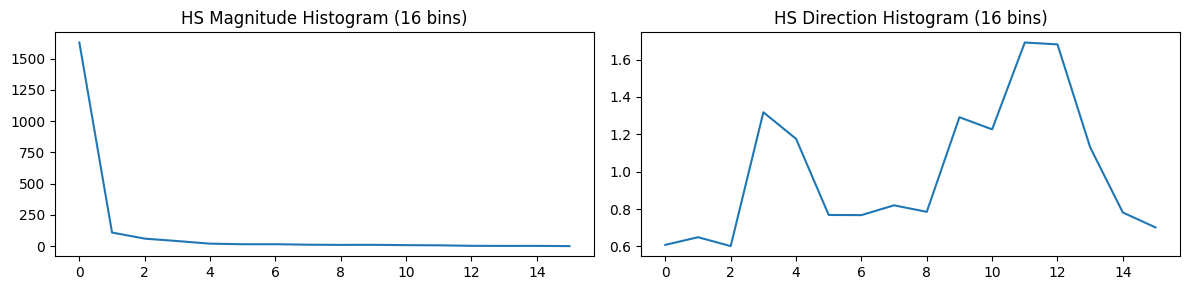

In [26]:
def hs_feature_vector(mag, ang_norm, mag_bins=16, ang_bins=16):
    # Stats
    stats = np.array([mag.mean(), mag.std(), mag.min(), mag.max()], dtype=np.float32)

    # Magnitude histogram
    mag_max = float(mag.max()) + 1e-6
    mag_hist, _ = np.histogram(mag.ravel(), bins=mag_bins, range=(0, mag_max), density=True)

    # Direction histogram (normalized 0..1)
    ang_hist, _ = np.histogram(ang_norm.ravel(), bins=ang_bins, range=(0, 1), density=True)

    # Dominant direction (bin center)
    dom_bin = int(np.argmax(ang_hist))
    dom_dir = (dom_bin + 0.5) / ang_bins  # 0..1

    # Include dominant direction + avg motion as explicit
    extras = np.array([mag.mean(), dom_dir], dtype=np.float32)

    feats = np.concatenate([stats, mag_hist.astype(np.float32), ang_hist.astype(np.float32), extras])
    feats = np.nan_to_num(feats, nan=0.0, posinf=0.0, neginf=0.0)
    return feats

hs_feats = hs_feature_vector(mag, ang_norm, mag_bins=16, ang_bins=16)
print("HS feature length:", len(hs_feats))
print("HS features (first 10):", hs_feats[:10])

# Visualization: histograms
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(hs_feats[4:4+16])
plt.title("HS Magnitude Histogram (16 bins)")
plt.subplot(1,2,2)
plt.plot(hs_feats[4+16:4+16+16])
plt.title("HS Direction Histogram (16 bins)")
plt.tight_layout()
plt.show()


def horn_schunck_dense_wrapper(frames_bgr, alpha=15.0, n_iter=120, flow_resize=(160,120),
                              mag_bins=16, ang_bins=16):
    """
    Wrapper to use in your extract_video_features().
    Returns:
      hs_feat (1D vector), (u,v), mag
    """
    if len(frames_bgr) < 2:
        feats = np.zeros(4 + mag_bins + ang_bins + 2, dtype=np.float32)
        return feats, (None, None), None

    u, v, mag, ang_norm = horn_schunck_dense(
        frames_bgr[0], frames_bgr[1],
        alpha=alpha,
        n_iter=n_iter,
        flow_resize=flow_resize
    )
    feats = hs_feature_vector(mag, ang_norm, mag_bins=mag_bins, ang_bins=ang_bins)
    return feats, (u, v), mag

### Temporal Features

#### Statistical measures of feature sequences (mean, std, min, max)

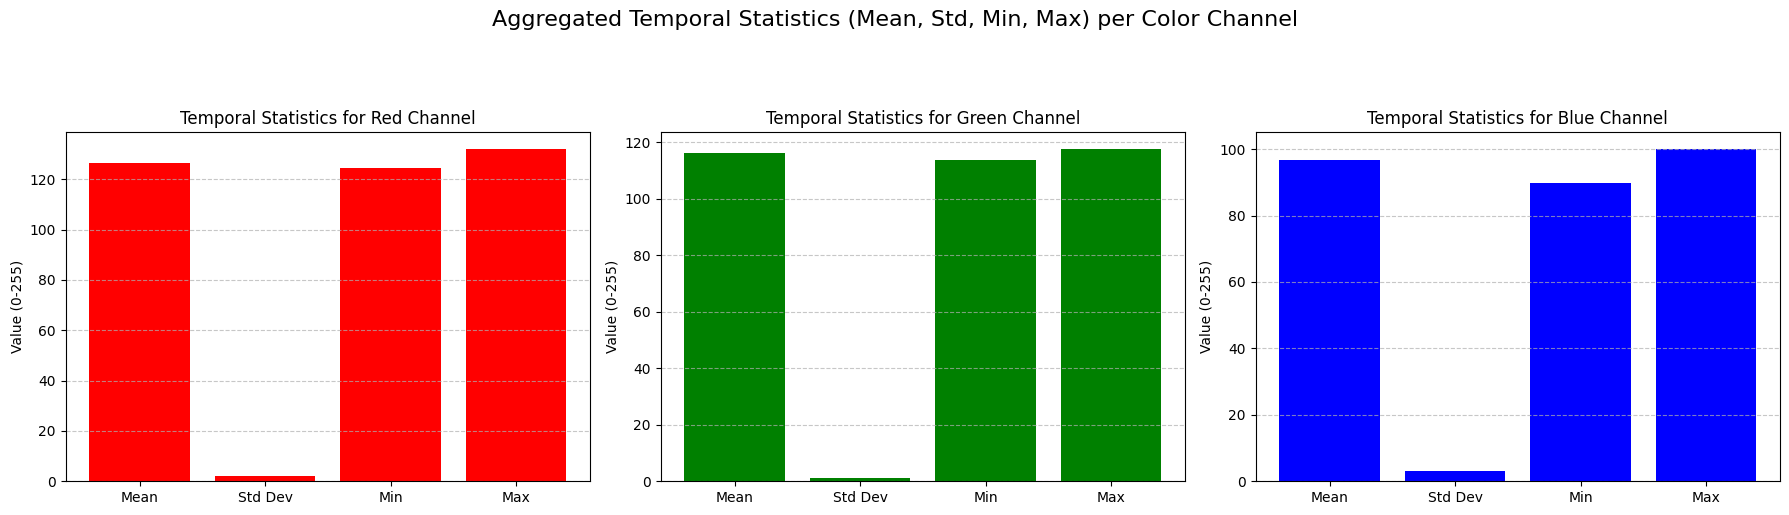

In [27]:
def avg_color(frame_bgr):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
    return rgb.reshape(-1,3).mean(axis=0)

avg_colors = [avg_color(f) for f in frames]
avg_colors_array = np.array(avg_colors)

def temporal_stats(feature_seq_2d):
 
    if feature_seq_2d is None or len(feature_seq_2d) == 0:
        return None
    x = np.asarray(feature_seq_2d, dtype=np.float32)
    mean = x.mean(axis=0)
    std  = x.std(axis=0)
    mn   = x.min(axis=0)
    mx   = x.max(axis=0)
    return np.concatenate([mean,std,mn,mx])
temporal_stats_output = temporal_stats(avg_colors_array)

if temporal_stats_output is not None:
    num_channels = avg_colors_array.shape[1] # Should be 3 for RGB

    # Extract stats for each channel
    
    # Red channel statistics
    red_stats = [
        temporal_stats_output[0], # mean_R
        temporal_stats_output[num_channels], # std_R
        temporal_stats_output[2 * num_channels], # min_R
        temporal_stats_output[3 * num_channels]  # max_R
    ]

    # Green channel statistics
    green_stats = [
        temporal_stats_output[1], # mean_G
        temporal_stats_output[num_channels + 1], # std_G
        temporal_stats_output[2 * num_channels + 1], # min_G
        temporal_stats_output[3 * num_channels + 1]  # max_G
    ]

    # Blue channel statistics
    blue_stats = [
        temporal_stats_output[2], # mean_B
        temporal_stats_output[num_channels + 2], # std_B
        temporal_stats_output[2 * num_channels + 2], # min_B
        temporal_stats_output[3 * num_channels + 2]  # max_B
    ]

    stats_labels = ['Mean', 'Std Dev', 'Min', 'Max']

    plt.figure(figsize=(18, 5))
    plt.suptitle('Aggregated Temporal Statistics (Mean, Std, Min, Max) per Color Channel', fontsize=16, y=1.05)

    # Red Channel Plot
    plt.subplot(1, 3, 1)
    plt.bar(stats_labels, red_stats, color='red')
    plt.title('Temporal Statistics for Red Channel')
    plt.ylabel('Value (0-255)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Green Channel Plot
    plt.subplot(1, 3, 2)
    plt.bar(stats_labels, green_stats, color='green')
    plt.title('Temporal Statistics for Green Channel')
    plt.ylabel('Value (0-255)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Blue Channel Plot
    plt.subplot(1, 3, 3)
    plt.bar(stats_labels, blue_stats, color='blue')
    plt.title('Temporal Statistics for Blue Channel')
    plt.ylabel('Value (0-255)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()
else:
    print("temporal_stats_output is None. Cannot plot statistics.")

#### Frame-to-frame variation analysis

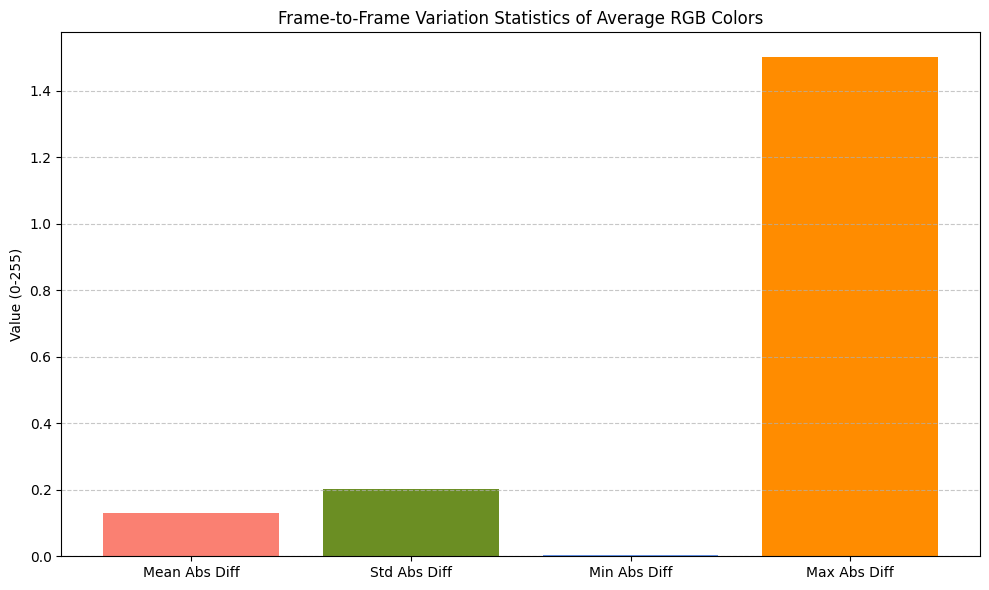

In [28]:
def frame_to_frame_variation(feature_seq_2d):
    if feature_seq_2d is None or len(feature_seq_2d) < 2:
        return np.zeros(4, dtype=np.float32)
    x = np.asarray(feature_seq_2d, dtype=np.float32)
    dif = np.abs(x[1:] - x[:-1]).mean(axis=1)  # (T-1,)
    return np.array([dif.mean(), dif.std(), dif.min(), dif.max()], dtype=np.float32)
frame_to_frame_stats = frame_to_frame_variation(avg_colors_array)

# Visualize frame-to-frame variation statistics
if frame_to_frame_stats is not None:
    variation_stats_labels = ['Mean Abs Diff', 'Std Abs Diff', 'Min Abs Diff', 'Max Abs Diff']

    plt.figure(figsize=(10, 6))
    plt.bar(variation_stats_labels, frame_to_frame_stats, color=['salmon', 'olivedrab', 'cornflowerblue', 'darkorange'])
    plt.title('Frame-to-Frame Variation Statistics of Average RGB Colors')
    plt.ylabel('Value (0-255)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Classical ML Model Training

Now we connect all outputs obtained by preprocessing 

* Load video
* Sample frames (uniform/random/dense choice)
* Resize + enhance
* Extract low-level + motion + temporal features
* Aggregate to video-level vector
* Standardize (imputer + scaler)
* Optional PCA
* Train SVM / RF / kNN
* Evaluate with all metrics + visualizations

### Unified feature extractor (video → feature vector)

In [29]:
def preprocess_frame(frame_bgr):
    frame_bgr = cv2.resize(frame_bgr, (RESIZE_W, RESIZE_H), interpolation=cv2.INTER_AREA)
    frame_bgr = enhance_frame(frame_bgr)
    return frame_bgr

def sample_frames_from_video(video_path, strategy="uniform", target_fps=1.0, k_random=16, max_frames_dense=120):
    cap, fps, nframes, w, h = load_video_opencv(video_path)
    frames = read_all_frames(video_path, max_frames=None)
    cap.release()

    if strategy == "dense":
        frames = frames[:max_frames_dense]  # cap for speed
        sampled = frames
    elif strategy == "random":
        sampled, _ = random_sampling(frames, k=k_random, rng=rng)
    else:  # uniform
        sampled, _ = uniform_sampling(frames, fps, target_fps=target_fps)
    return sampled, fps

def extract_frame_features(frame_bgr):
    # Color
    f_color = np.concatenate([
        color_hist_rgb(frame_bgr, bins=16),
        color_hist_hsv(frame_bgr, bins=16),
        color_moments(frame_bgr),
        avg_color(frame_bgr)
    ]).astype(np.float32)

    # Texture
    f_glcm = glcm_features(frame_bgr)
    f_lbp, _ = lbp_features(frame_bgr)
    f_gabor = gabor_features(frame_bgr)

    # Shape
    f_edge, _ = edge_histogram(frame_bgr)
    f_cont = contour_features(frame_bgr)
    f_hog = hog_features(frame_bgr)

    return np.concatenate([f_color, f_glcm, f_lbp, f_gabor, f_edge, f_cont, f_hog]).astype(np.float32)

def extract_video_features(video_abs_path, sampling="uniform"):
    frames, fps = sample_frames_from_video(video_abs_path, strategy=sampling, target_fps=1.0, k_random=16)
    frames = [preprocess_frame(f) for f in frames]

    # Per-frame features
    frame_feats = [extract_frame_features(f) for f in frames]
    frame_feats = np.vstack(frame_feats) if len(frame_feats) else None

    # Temporal aggregation of frame-level features
    temp = temporal_stats(frame_feats) if frame_feats is not None else None
    var  = frame_to_frame_variation(frame_feats) if frame_feats is not None else np.zeros(4, dtype=np.float32)

    # Motion features from frames
    subset = frames[:10]
    fd_feat, _ = frame_diff_features(subset)
    lk_feat, _ = lucas_kanade_sparse(subset[:2])
    hs_feat, _, _ = horn_schunck_dense_wrapper(subset[:2], alpha=15.0, n_iter=120, flow_resize=(160,120))
    # If no frames, fallback zeros
    if temp is None:
        D = 2000
        temp = np.zeros(4*D, dtype=np.float32)

    video_vector = np.concatenate([temp, var, fd_feat, lk_feat, hs_feat]).astype(np.float32)

    # Replaces invalid values if any
    video_vector = np.nan_to_num(video_vector, nan=0.0, posinf=0.0, neginf=0.0)
    return video_vector

### Building feature matrices for train/val/test

In [30]:
def build_Xy(rows, sampling="random", limit=None):
    X, y = [], []
    t0 = time.time()
    for i, (rel, lab) in enumerate(rows):
        if limit and i >= limit:
            break
        video_abs = os.path.join(DATA_ROOT, rel)
        feats = extract_video_features(video_abs, sampling=sampling)
        X.append(feats)
        y.append(lab)
        if (i+1) % 10 == 0:
            print(f"[{sampling}] processed {i+1}/{len(rows)}")
    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    print(f"Built X,y for {sampling}: X={X.shape}, y={y.shape}, time={time.time()-t0:.1f}s")
    return X, y

X_train, y_train = build_Xy(train_rows, sampling="random", limit=None)
X_val, y_val     = build_Xy(val_rows, sampling="uniform", limit=None)
X_test, y_test   = build_Xy(test_rows, sampling="dense", limit=None)

print("Feature dimension:", X_train.shape[1])

[random] processed 10/54
[random] processed 20/54
[random] processed 30/54
[random] processed 40/54
[random] processed 50/54
Built X,y for random: X=(54, 163828), y=(54,), time=259.1s
[uniform] processed 10/12
Built X,y for uniform: X=(12, 163828), y=(12,), time=19.8s
Built X,y for dense: X=(9, 163828), y=(9,), time=234.1s
Feature dimension: 163828


#### Missing Detail handling + StandardScaler(Normalization)

Scaled feature stats: train mean~ -1.3025672984667835e-08 train std~ 0.9989040493965149


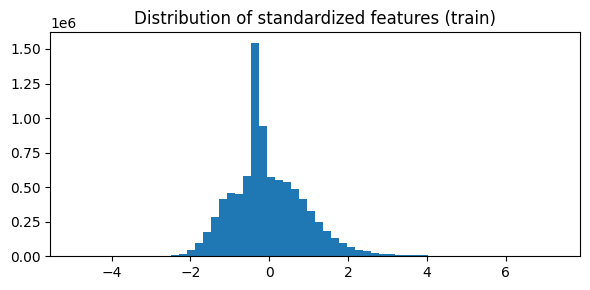

In [31]:
prep = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_train_s = prep.fit_transform(X_train)
X_val_s   = prep.transform(X_val)
X_test_s  = prep.transform(X_test)

print("Scaled feature stats:", 
      "train mean~", float(X_train_s.mean()), 
      "train std~", float(X_train_s.std()))

plt.figure(figsize=(6,3))
plt.hist(X_train_s.ravel(), bins=60)
plt.title("Distribution of standardized features (train)")
plt.tight_layout(); plt.show()

#### PCA and its Explained Variance Plot

PCA reduced: (54, 163828) -> (54, 45)


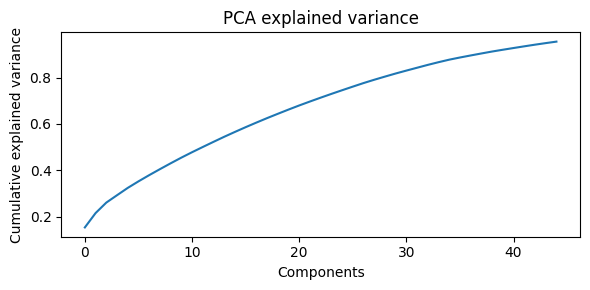

In [32]:
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)  # keeping 95% variance
X_train_p = pca.fit_transform(X_train_s)
X_val_p   = pca.transform(X_val_s)
X_test_p  = pca.transform(X_test_s)

print("PCA reduced:", X_train_s.shape, "->", X_train_p.shape)
plt.figure(figsize=(6,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance")
plt.tight_layout(); plt.show()

### Train Classical ML Models

We are performing training:

* SVM (Linear + RBF) with CV tuning
* Random Forest with feature importance
* kNN with k selection

#### Shared evaluation utilities (Evaluation metrics + Plots)

In [33]:
def plot_confmat(y_true, y_pred, class_count, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    class_labels = [f"Class {i}" for i in range(class_count)]
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout(); plt.show()

def report_all(y_true, y_pred, class_count, title=""):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=np.arange(class_count))
    pm, rm, f1m, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    print(f"\n=== {title} ===")
    print("Accuracy:", acc)
    print("Macro Precision/Recall/F1:", pm, rm, f1m)
    print("Per-class Precision:", p)
    print("Per-class Recall:", r)
    print("Per-class F1:", f1)
    plot_confmat(y_true, y_pred, class_count, title=title)

def plot_multiclass_roc(y_true, y_score, n_classes, title="ROC (OvR)"):
    # y_score: (N, C) probabilities or decision scores
    y_bin = label_binarize(y_true, classes=np.arange(n_classes))
    plt.figure(figsize=(6,5))
    for c in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:,c], y_score[:,c])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"class {c} AUC={roc_auc:.2f}")
    plt.plot([0,1],[0,1],'k--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout(); plt.show()

### 1)SVM (Linear + RBF) with CV tuning

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best SVM params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM train time: 8.335131406784058 sec

=== SVM Best (Test) ===
Accuracy: 0.5555555555555556
Macro Precision/Recall/F1: 0.5333333333333333 0.5555555555555555 0.5166666666666667
Per-class Precision: [0.5 0.5 0.6]
Per-class Recall: [0.33333333 0.33333333 1.        ]
Per-class F1: [0.4  0.4  0.75]


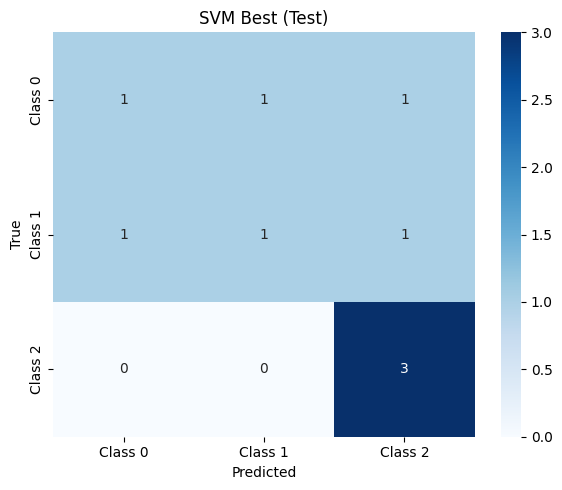

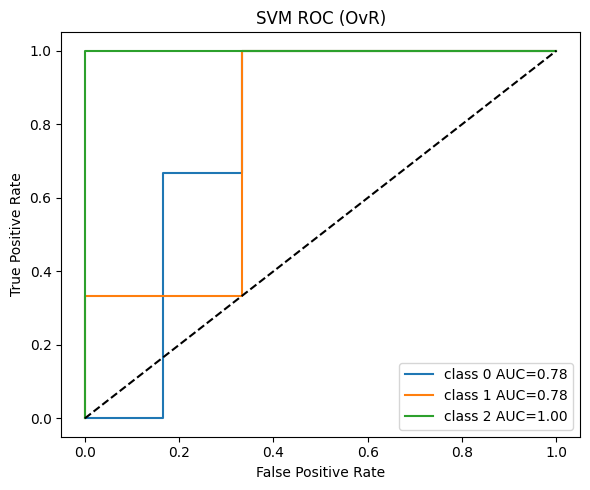

Serialized SVM model size (KB): 21.0810546875
Inference time total (sec): 0.0004913806915283203 | per video (ms): 0.05459785461425781


In [34]:
n_classes = int(max(y_train.max(), y_val.max(), y_test.max()) + 1)

param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", 0.01, 0.001]  # used for rbf; ignored for linear
}

svm = SVC(probability=True, random_state=RANDOM_STATE)

t0 = time.time()
gs = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1, verbose=1)
gs.fit(X_train_p, y_train)
train_time = time.time() - t0

print("Best SVM params:", gs.best_params_)
print("SVM train time:", train_time, "sec")

best_svm = gs.best_estimator_

t1 = time.time()
y_pred = best_svm.predict(X_test_p)
infer_time = time.time() - t1

report_all(y_test, y_pred, n_classes, title="SVM Best (Test)")

y_score = best_svm.predict_proba(X_test_p)
plot_multiclass_roc(y_test, y_score, n_classes, title="SVM ROC (OvR)")

# Serialized Model size
joblib.dump(best_svm, "svm_model.joblib")
print("Serialized SVM model size (KB):", os.path.getsize("svm_model.joblib")/1024)
print("Inference time total (sec):", infer_time, "| per video (ms):", 1000*infer_time/len(y_test))

### 2) Random Forest (importance + tuning)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} | train time: 1.5985510349273682

=== Random Forest (Test) ===
Accuracy: 0.7777777777777778
Macro Precision/Recall/F1: 0.8666666666666667 0.7777777777777777 0.75
Per-class Precision: [1.  0.6 1. ]
Per-class Recall: [0.33333333 1.         1.        ]
Per-class F1: [0.5  0.75 1.  ]


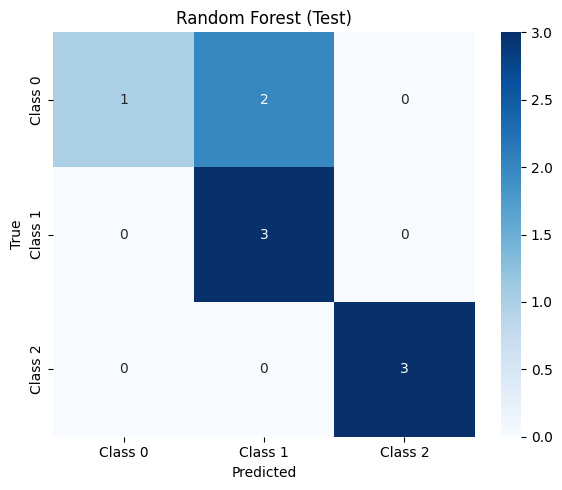

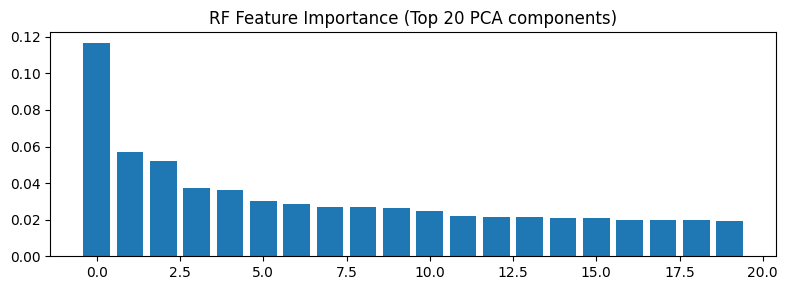

RF model size (KB): 431.3603515625
RF inference per video (ms): 3.451320860120985


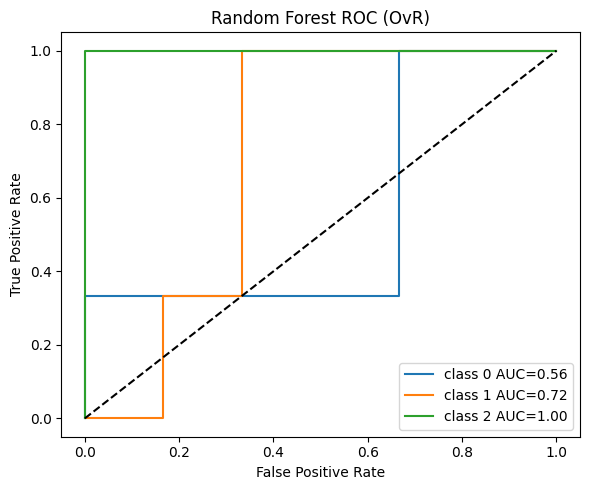

In [35]:
rf_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 20, 40],
    "min_samples_split": [2, 5]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

t0 = time.time()
gs_rf = GridSearchCV(rf, rf_grid, cv=3, n_jobs=-1, verbose=1)
gs_rf.fit(X_train_p, y_train)
rf_train_time = time.time() - t0

best_rf = gs_rf.best_estimator_
print("Best RF params:", gs_rf.best_params_, "| train time:", rf_train_time)

t1 = time.time()
y_pred_rf = best_rf.predict(X_test_p)
rf_infer = time.time() - t1

report_all(y_test, y_pred_rf, n_classes, title="Random Forest (Test)")

# Feature importance (top-20)
importances = best_rf.feature_importances_
idx = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(8,3))
plt.bar(np.arange(20), importances[idx])
plt.title("RF Feature Importance (Top 20 PCA components)")
plt.tight_layout(); plt.show()

joblib.dump(best_rf, "rf_model.joblib")
print("RF model size (KB):", os.path.getsize("rf_model.joblib")/1024)
print("RF inference per video (ms):", 1000*rf_infer/len(y_test))

y_score_rf = best_rf.predict_proba(X_test_p)
plot_multiclass_roc(y_test, y_score_rf, n_classes, title="Random Forest ROC (OvR)")

### 3) k-NN (distance metric + k selection)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best kNN params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'} | train time: 0.2781352996826172

=== k-NN (Test) ===
Accuracy: 0.4444444444444444
Macro Precision/Recall/F1: 0.4583333333333333 0.4444444444444444 0.34848484848484845
Per-class Precision: [0.    1.    0.375]
Per-class Recall: [0.         0.33333333 1.        ]
Per-class F1: [0.         0.5        0.54545455]


c:\Users\avashist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\avashist\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


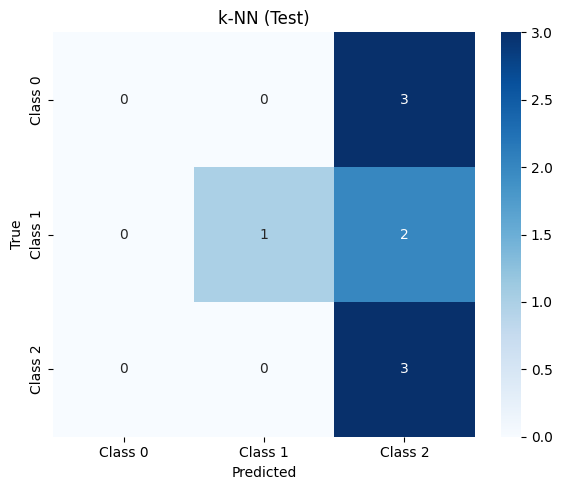

kNN model size (KB): 10.6982421875
kNN inference per video (ms): 287.1730857425266


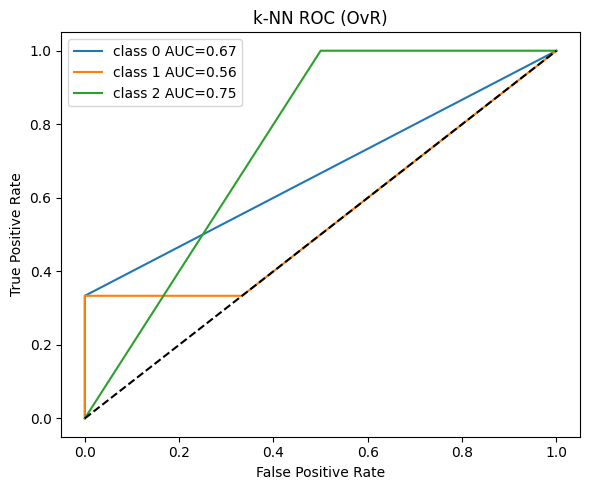

In [36]:
knn_grid = {
    "n_neighbors": [3,5,7,9,11,15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

knn = KNeighborsClassifier()

t0 = time.time()
gs_knn = GridSearchCV(knn, knn_grid, cv=3, n_jobs=-1, verbose=1)
gs_knn.fit(X_train_p, y_train)
knn_train_time = time.time() - t0

best_knn = gs_knn.best_estimator_
print("Best kNN params:", gs_knn.best_params_, "| train time:", knn_train_time)

t1 = time.time()
y_pred_knn = best_knn.predict(X_test_p)
knn_infer = time.time() - t1

report_all(y_test, y_pred_knn, n_classes, title="k-NN (Test)")

joblib.dump(best_knn, "knn_model.joblib")
print("kNN model size (KB):", os.path.getsize("knn_model.joblib")/1024)
print("kNN inference per video (ms):", 1000*knn_infer/len(y_test))

y_score_knn = best_knn.predict_proba(X_test_p)
plot_multiclass_roc(y_test, y_score_knn, n_classes, title="k-NN ROC (OvR)")

## Refinement, Optimization & Analysis

### Error analysis: showing failure cases (visualize sample videos)

Total wrong: 4
FAIL: Basketball/v_Basketball_g14_c05.avi true=0 pred=1


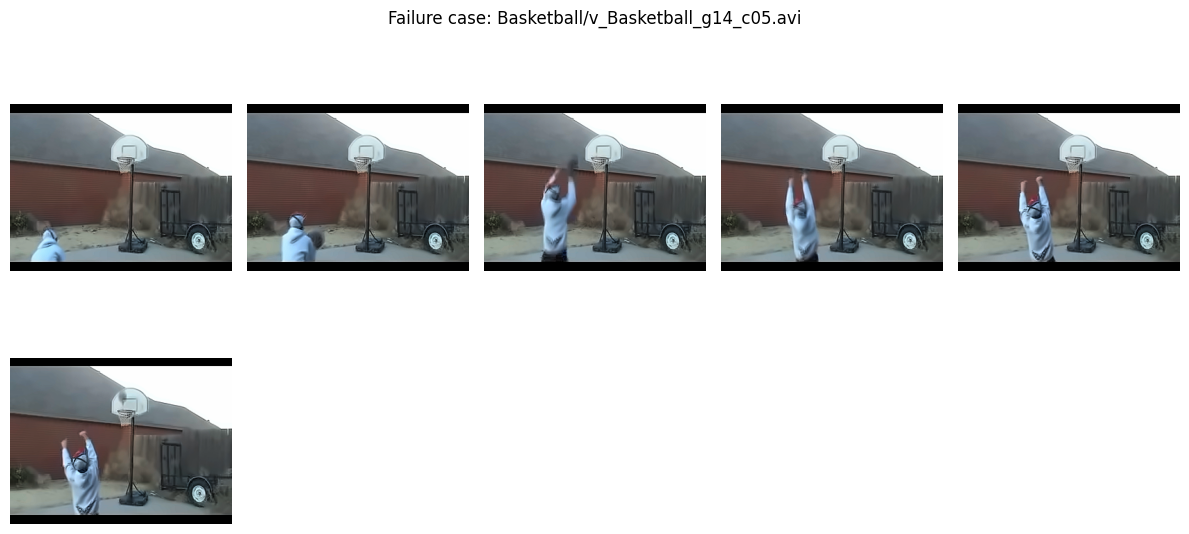

FAIL: Basketball/v_Basketball_g02_c06.avi true=0 pred=2


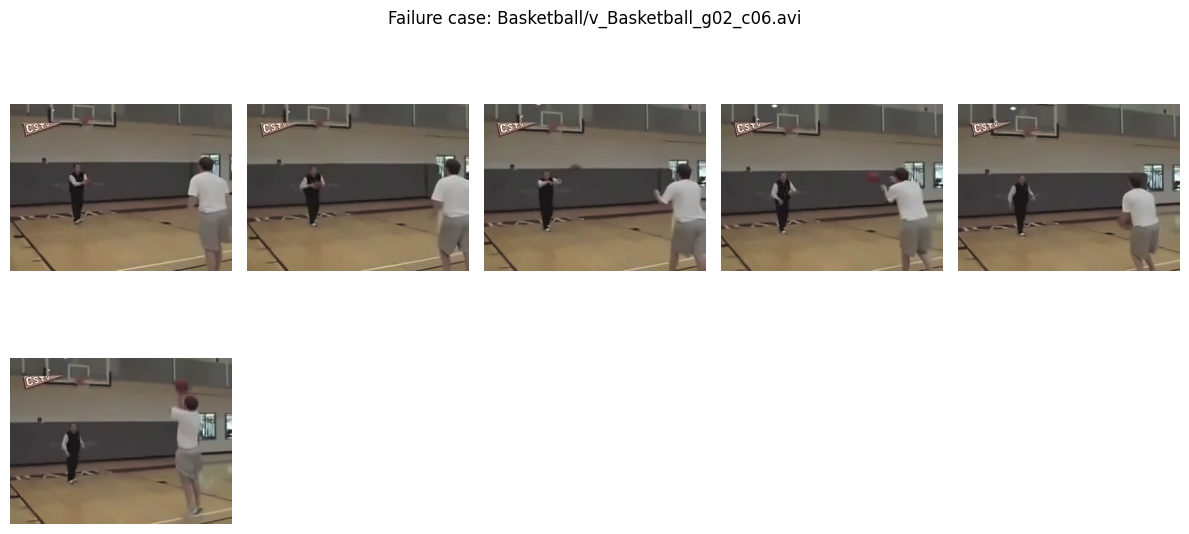

In [38]:
def show_failure_cases(rows, y_true, y_pred, max_cases=3):
    wrong = np.where(y_true != y_pred)[0]
    print("Total wrong:", len(wrong))
    for j in wrong[:max_cases]:
        rel, lab = rows[j]
        print(f"FAIL: {rel} true={y_true[j]} pred={y_pred[j]}")
        video_abs = os.path.join(DATA_ROOT, rel)
        frs = read_all_frames(video_abs, max_frames=60)
        frs = [preprocess_frame(f) for f in frs]
        show_frames_grid(frs[::10], title=f"Failure case: {rel}", cols=5)

# Example with SVM predictions:
show_failure_cases(test_rows, y_test, y_pred, max_cases=2)

### Post-processing temporal smoothing

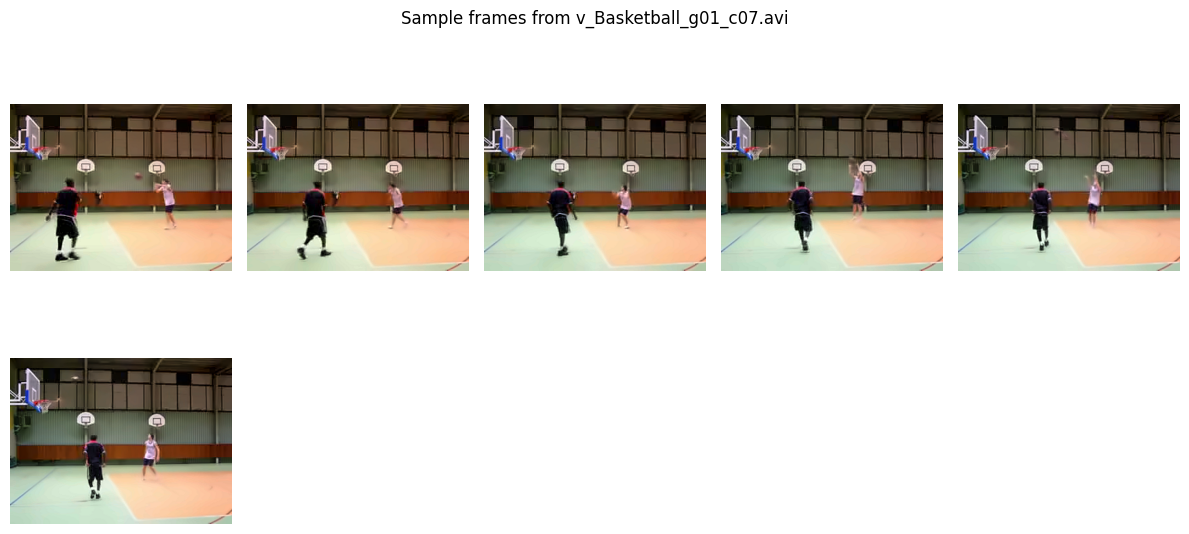


Segment-wise predictions (for 5 segments): [0, 0, 0, 0, 0]
Final smoothed prediction (majority vote): 0


In [37]:
def segment_video_predictions(video_abs, model, prep, pca, n_segments=3):
    frames, fps = sample_frames_from_video(video_abs, strategy="dense", max_frames_dense=120)
    frames = [preprocess_frame(f) for f in frames]
    if len(frames) < n_segments:
        n_segments = 1

    segs = np.array_split(frames, n_segments)
    preds = []
    for seg in segs:
        if len(seg) == 0: # Handle empty segments if np.array_split results in them
            continue
        frame_feats = [extract_frame_features(f) for f in seg]
        frame_feats = np.vstack(frame_feats) if len(frame_feats) else None

        temp = temporal_stats(frame_feats) if frame_feats is not None else None
        var  = frame_to_frame_variation(frame_feats) if frame_feats is not None else np.zeros(4, dtype=np.float32)

        # Motion features require at least 2 frames for some functions
        fd_feat, _, = frame_diff_features(seg[:10])
        lk_feat, _ = lucas_kanade_sparse(seg[:2])
        hs_feat, _, _ = horn_schunck_dense_wrapper(seg[:2])

        if temp is None:
            dummy_frame = np.zeros((RESIZE_H, RESIZE_W, 3), dtype=np.uint8)
            dummy_frame_feats = extract_frame_features(dummy_frame)
            D_frame_features = len(dummy_frame_feats)
            expected_full_len = 4 * D_frame_features + 4 + 24 + 10 + 38
            temp = np.zeros(4 * D_frame_features, dtype=np.float32)
            video_vector = np.concatenate([temp, var, fd_feat, lk_feat, hs_feat]).astype(np.float32)
            if len(video_vector) != expected_full_len:
                print(f"Warning: Mismatch in expected feature length ({expected_full_len}) vs actual ({len(video_vector)}). Adjusting.")

                pass # Let it proceed with the calculated vector and rely on imputer/PCA to handle it.
        else:
            video_vector = np.concatenate([temp, var, fd_feat, lk_feat, hs_feat]).astype(np.float32)


        vec = np.nan_to_num(video_vector, nan=0.0, posinf=0.0, neginf=0.0)

        vec_s = prep.transform(vec.reshape(1,-1))
        vec_p = pca.transform(vec_s)
        preds.append(int(model.predict(vec_p)[0]))

    final = Counter(preds).most_common(1)[0][0]
    return preds, final

# Visualization

# Sample and preprocess frames for visual context
all_frames_for_vis = read_all_frames(sample_abs, max_frames=60) # Limit for visualization
preprocessed_frames_for_vis = [preprocess_frame(f) for f in all_frames_for_vis]

# Display a subset of these frames
show_frames_grid(preprocessed_frames_for_vis[::10], title=f"Sample frames from {os.path.basename(sample_abs)}", cols=5)

# Apply segment_video_predictions
n_segments = 5
segment_predictions, final_smoothed_prediction = segment_video_predictions(
    sample_abs, best_svm, prep, pca, n_segments=n_segments
)

# Print the results
print(f"\nSegment-wise predictions (for {n_segments} segments): {segment_predictions}")
print(f"Final smoothed prediction (majority vote): {final_smoothed_prediction}")

## Metrics & Computational Analysis

  model  train_time_sec  infer_time_per_video_ms  model_size_kb  \
0   SVM        8.335131                 0.054598      21.081055   
1    RF        1.598551                 3.451321     431.360352   
2   kNN        0.278135               287.173086      10.698242   

   feature_matrix_mb  
0          33.747528  
1          33.747528  
2          33.747528  


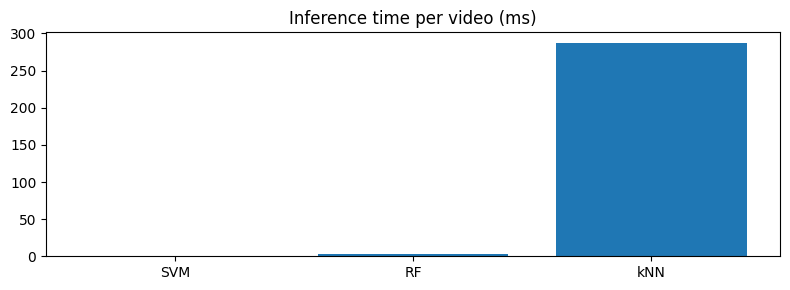

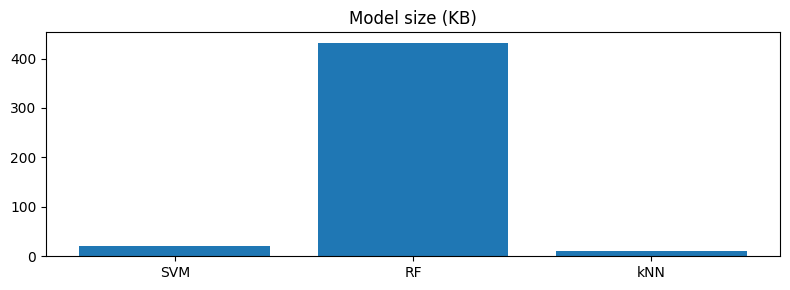

In [38]:
def approx_feature_memory_mb(X):
    return X.nbytes / (1024**2)

results = []

def add_result(name, train_time, infer_time_total, model_file):
    results.append({
        "model": name,
        "train_time_sec": train_time,
        "infer_time_per_video_ms": 1000*infer_time_total/len(y_test),
        "model_size_kb": os.path.getsize(model_file)/1024,
        "feature_matrix_mb": approx_feature_memory_mb(X_train)
    })

# Fill from runs performed above
add_result("SVM", train_time, infer_time, "svm_model.joblib")
add_result("RF",  rf_train_time, rf_infer, "rf_model.joblib")
add_result("kNN", knn_train_time, knn_infer, "knn_model.joblib")

df = pd.DataFrame(results)
print(df)

if len(df):
    plt.figure(figsize=(8,3))
    plt.bar(df["model"], df["infer_time_per_video_ms"])
    plt.title("Inference time per video (ms)")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,3))
    plt.bar(df["model"], df["model_size_kb"])
    plt.title("Model size (KB)")
    plt.tight_layout(); plt.show()

### Feature Analysis: t‑SNE / UMAP Visualization

#### t‑SNE

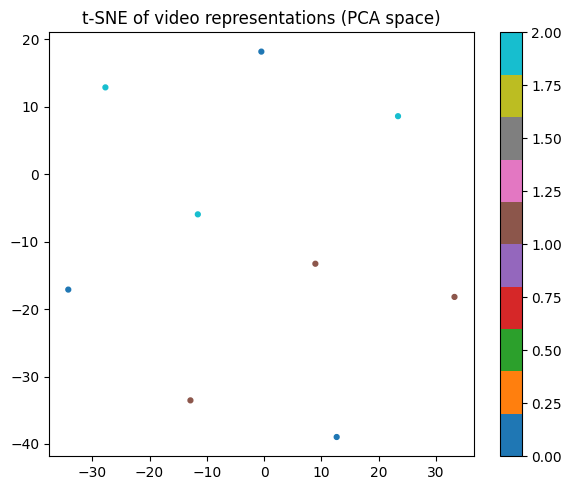

In [39]:
X_embed = X_test_p
y_embed = y_test

n_samples = X_embed.shape[0]
if n_samples < 2:raise ValueError("t-SNE requires at least 2 samples.")

perplexity = max(2, min(30, n_samples - 1))

tsne_kwargs = dict(
n_components=2,
random_state=RANDOM_STATE,
perplexity=perplexity,
learning_rate='auto',
init='pca'
)

try:tsne = TSNE(**tsne_kwargs, n_iter=2000)
except TypeError:
    tsne = TSNE(**tsne_kwargs, max_iter=2000)

Z = tsne.fit_transform(X_embed)

plt.figure(figsize=(6, 5))
plt.scatter(Z[:, 0], Z[:, 1], c=y_embed, cmap='tab10', s=12)
plt.title('t-SNE of video representations (PCA space)')
plt.colorbar()
plt.tight_layout()
plt.show()

#### UMAP 

c:\Users\avashist\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\avashist\.venv\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


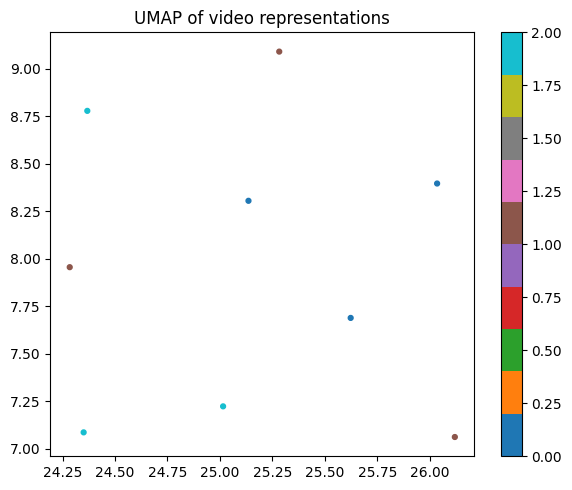

In [40]:
reducer = umap.UMAP(random_state=RANDOM_STATE)
Z2 = reducer.fit_transform(X_test_p)
plt.figure(figsize=(6,5))
plt.scatter(Z2[:,0], Z2[:,1], c=y_test, cmap="tab10", s=12)
plt.title("UMAP of video representations")
plt.colorbar()
plt.tight_layout(); plt.show()


## Comparative Analysis (All Models)

#### Performance comparison plot (Accuracy/F1 for all)

  model  accuracy  macro_f1
0   SVM  0.555556  0.516667
1    RF  0.777778  0.750000
2   kNN  0.444444  0.348485


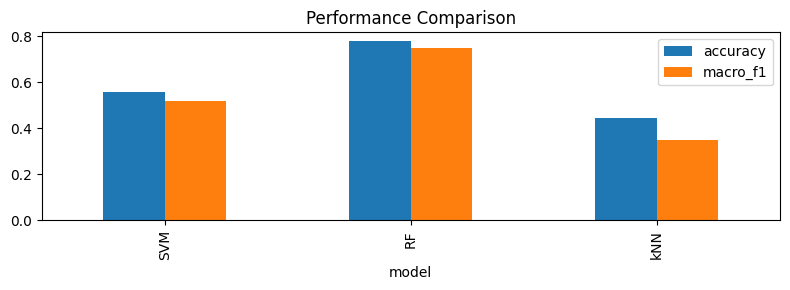

In [41]:
def add_perf(name, y_pred):
    return {"model": name,
            "accuracy": accuracy_score(y_test, y_pred),
            "macro_f1": f1_score(y_test, y_pred, average="macro")}

perf = []
perf.append(add_perf("SVM", y_pred))
perf.append(add_perf("RF", y_pred_rf))
perf.append(add_perf("kNN", y_pred_knn))

perf_df = pd.DataFrame(perf)
print(perf_df)

if len(perf_df):
    perf_df.plot(x="model", y=["accuracy","macro_f1"], kind="bar", figsize=(8,3))
    plt.title("Performance Comparison")
    plt.tight_layout(); plt.show()

### Comparative Analysis: Deployment, Real-time & Maintenance

#### 1. Deployment Considerations

**A. Suitable for Edge Deployment**

For edge deployments, where computational resources, power, and bandwidth are typically constrained, models need to be lightweight and efficient. Based on our analysis:

*   **kNN**: Generally *less suitable* for edge deployment due to its instance-based learning nature. Inference requires comparing new samples against all (or a significant portion) of the training data, which can be computationally intensive and memory-heavy, especially with large datasets.
*   **Random Forest**: Offers *moderate suitability*. While Random Forests can be optimized, their size depends on the number of trees and depth. They can run on CPUs, making them feasible for some edge devices, but might still be too large or slow for very constrained environments.
*   **Linear SVM**: Often the *most suitable* choice for highly constrained edge environments. Linear SVMs typically result in very small models (a weight vector and bias) and offer extremely fast inference. If the accuracy achieved by a linear SVM is acceptable, it's often the best trade-off for edge-specific challenges.

**Edge Pick**: A **Linear SVM** (or a small, carefully tuned Random Forest) combined with **uniform sampling (e.g., 1 fps)** and **PCA-reduced features** would be the most robust choice for edge deployment.

**B. Suitable for Cloud Deployment**

Cloud deployments offer scalable computational resources, ample memory, and high bandwidth, allowing for more complex models and extensive processing. Here, the focus shifts from extreme efficiency to maximizing performance and leveraging richer data:

*   **Dense Sampling**: Utilizing more frames from videos allows the model to capture finer temporal details, improving overall accuracy.
*   **Larger Feature Sets**: More extensive feature extraction (e.g., higher-dimensional color histograms, more detailed GLCM/Gabor configurations, or even incorporating deep learning features) can be employed without performance bottlenecks.
*   **Grid Search and Ensembling**: More aggressive hyperparameter tuning (e.g., for RBF SVMs or larger Random Forests) and model ensembling techniques can be used to boost predictive power.

**Cloud Pick**: An **RBF SVM** or a **Random Forest with a larger number of estimators and deeper trees** would be ideal, potentially leveraging more aggressive frame sampling strategies like dense sampling to achieve higher accuracy.

#### 2. Real-time Processing Feasibility

Achieving real-time processing capability is primarily governed by the **sampling rate** and the **computational cost of feature extraction**, particularly for motion features.

*   **Sampling Rate**: Uniform sampling at a lower frame rate (e.g., 1 frame per second or every 5th frame) drastically reduces the number of frames to process, making real-time feasible. Dense sampling, while capturing more detail, is often too slow for real-time applications.
*   **Optical Flow Cost**: Horn–Schunck (HS) dense optical flow is computationally very expensive due to its iterative nature and per-pixel calculations. Lucas–Kanade (LK) sparse optical flow, which tracks only a few salient points, is significantly faster.

**For Real-time Implementation**: It's crucial to:

*   **Eliminate Horn–Schunck Dense Flow**: Replace it with lighter alternatives or remove it entirely.
*   **Retain Frame Differencing and Lucas–Kanade Sparse Flow**: These motion features provide valuable information at a lower computational cost.
*   **Employ Uniform Sampling**: A sparse uniform sampling strategy (e.g., 1 frame per second or every 5th frame) is essential to limit the processing load.

#### 3. Maintenance and Update Considerations

Classical machine learning pipelines, while requiring careful feature engineering, often offer clearer interpretability and easier maintenance compared to complex deep learning models.

*   **Consistency in Feature Engineering**: Any changes to the feature extraction process (e.g., resizing, enhancement, specific feature parameters) necessitate re-evaluation and potentially re-training to maintain model performance.
*   **Dataset Changes**: If the underlying video dataset changes (e.g., new classes are added, or existing classes have new examples), the entire pipeline needs to be updated:
    *   **Re-run Feature Extraction**: New features must be extracted from the updated dataset.
    *   **Re-fit Scaler and PCA**: The `StandardScaler` and `PCA` components must be re-fitted on the updated training data to ensure consistent data normalization and dimensionality reduction.
    *   **Re-train Models**: All classifiers (SVM, Random Forest, kNN) must be re-trained on the new feature matrices to adapt to the changes in the data distribution.